# NAB Results exploration

This notebook is created for the reasons of analysis of results of unsupervised pipeline experiments on NAB datasets.

In [1]:
from joblib import load
import json
import os
import yaml

from config import (
    MODEL_DIR,
    CONFIG_DIR,
    DATASET_DIR,
    TRAIN_DATASETS,
    TEST_DATASETS
)
from latex_figures import (
    set_size
)
from utils import (
    get_yaml_config,
    read_file
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib inline

tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update(tex_fonts)

In [2]:


EXPERIMENTS = [
    'unsupervised',
    'unsupervised_ae',
    'unsupervised_aev2',
    'unsupervised_vaev2',
]
metrics = ['em', 'mv']

detectors_dict = {
    'knn': 'k-NN',
    'lof': 'LOF',
    'isoforest': 'IF',
    'ocsvm': 'OCSVM',
    'dwtmlead': 'DWTMLEAD',
    'vae': 'VAE',
    'lstmae': 'LSTM EncDec',
    'tranad': 'TranAD',
    'gta': 'GTA',
}
experiments_dict = {
    'unsupervised': 'US',
    'unsupervised_ae': 'EUS',
    'unsupervised_aev2': 'EUS-AE',
    'unsupervised_vae': 'EUSv',
    'unsupervised_vaev2': 'EUS-VAE',
}



## Baseline
This experiment serves as a baseline for other experiments.

Key features:
* Completely unsupervised
* No AutoML used
* Default parameters of anomaly detectors used for learning

In [3]:
# Read results
baseline_df = pd.read_csv(
    './results/numenta_baseline_results.csv', sep=',', header=0
)
baseline_df['detector'] = baseline_df['detector'].map(detectors_dict)
baseline_df['exp'] = 'Base'
baseline_df.head()

,detector,dataset,f1,f1_pa_auc,f1_pa,f1_pa_ts_auc,aucpr,aucroc,time,exp
0,k-NN,exchange-2_cpm_results.csv,0.515789,0.626761,1.000000,0.355495,0.498872,0.782667,0.529049,Base
1,k-NN,exchange-3_cpc_results.csv,0.666667,0.740789,1.000000,0.222727,0.599853,0.915104,0.517097,Base
2,k-NN,exchange-4_cpc_results.csv,0.576923,0.717461,1.000000,0.541045,0.647697,0.936728,0.648244,Base
3,k-NN,exchange-4_cpm_results.csv,0.860465,0.893440,1.000000,0.927026,0.951986,0.994289,0.470886,Base
4,k-NN,ec2_cpu_utilization_5f5533.csv,0.183655,0.183613,0.995025,0.164635,0.147491,0.443007,0.768820,Base


Plot baseline results

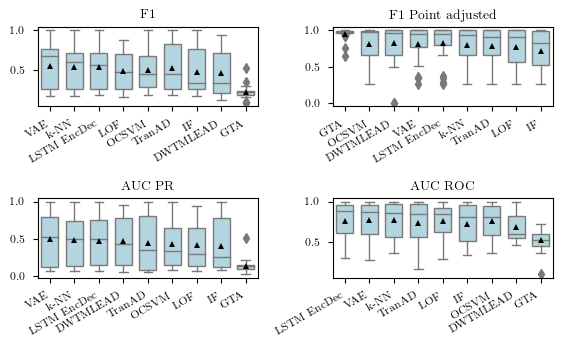

In [4]:
fig, axs = plt.subplots(2, 2, figsize=set_size(subplots=(2, 2)))
to_label = dict(
    f1='F1', f1_pa='F1 Point adjusted', aucpr='AUC PR', aucroc='AUC ROC'
)
for i, y in enumerate(['f1', 'f1_pa', 'aucpr', 'aucroc']):
    ax = axs[i // 2][i % 2]

    order = (
        baseline_df.groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )

    ax = sns.boxplot(
        data=baseline_df,
        y=y,
        x='detector',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=30, horizontalalignment='right'
    )

plt.tight_layout()
plt.show()
# fig.savefig('images/numenta_baseline.pdf', format='pdf', bbox_inches='tight')


## AutoML using unsupervised metrics

This section is mainly focused on Mass volume and Excess mass metrics.

Experiments from now on are evaluated only with F1 score and AUC PR as AUC ROC
isn't as informative as AUC-PR for this task and point
adjusted evaluation scheme isn't used as it has been shown it can overestimate
performance of detectors.

Key features:

* Mass volume and Excess mass metrics used to tune hyperparameters

Research questions: 

* Is one superior to another in our results?
* Do they actually work for time series?
* Can they be used to compare between detectors?



In [5]:
# Read results
with open('./data/datasets/numenta/combined_labels.json', 'r') as f:
    labels = json.load(f)

path = 'data/datasets/numenta'
datasets = [
    f
    for f in os.listdir(path)
    if os.path.isfile(os.path.join(path, f)) and f.endswith('.csv')
]

dataframes = []
for exp in EXPERIMENTS:
    detectors = get_yaml_config('./config/' + exp)['detectors']

    records = []
    for d in detectors:
        for m in metrics:
            for dt in datasets:
                with open(f'./model/{d}/numenta_{exp}/{dt}/{m}.yaml') as f:
                    r = yaml.unsafe_load(f)
                    r['detector'] = detectors_dict[d]
                    r['metric_value'] = r.pop('metric')
                    r['metric'] = 'EM' if m == 'em' else 'MV'
                    r['dataset'] = dt
                    r['exp'] = experiments_dict[exp]
                    records.append(r)
    dataframes.append(pd.DataFrame.from_records(records))

us1_df = dataframes[0]  # unsupervised default experiment
us2_df = dataframes[1]  # unsupervised default experiment
us3_df = dataframes[2]  # unsupervised autoencoder within the metric
us5_df = dataframes[3]  # unsupervised vae within the metric


Comparison of MV and EM metrics on individual models of US pipeline

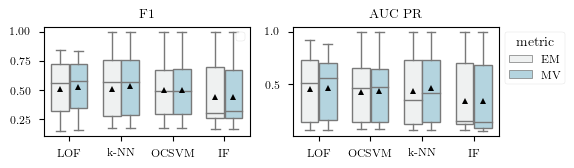

In [6]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us1_df.groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=us1_df,
        y=y,
        x='detector',
        hue='metric',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])
sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
# fig.savefig('images/numenta_us1.pdf', format='pdf', bbox_inches='tight')


Comparison of metrics across all models

/tmp/ipykernel_3023381/3428329742.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = us1_df.groupby(['metric', 'dataset']).median()


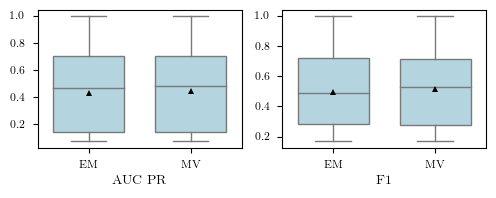

In [7]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
d = us1_df.groupby(['metric', 'dataset']).median()
ax = sns.boxplot(
    data=d.reset_index(),
    y='f1',
    x='metric',
    color='lightblue',
    ax=axs[1],
    linewidth=1,
    width=0.7,
    showmeans=True,
    meanprops={
        'marker': '^',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'markersize': '4',
    },
)
ax.set_xlabel('F1')
ax.set_ylabel('')
ax = sns.boxplot(
    data=d.reset_index(),
    y='aucpr',
    x='metric',
    color='lightblue',
    ax=axs[0],
    linewidth=1,
    width=0.7,
    showmeans=True,
    meanprops={
        'marker': '^',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'markersize': '4',
    },
)
ax.set_xlabel('AUC PR')
ax.set_ylabel('')
plt.show()
# fig.savefig('images/numenta_metrics.pdf', format='pdf', bbox_inches='tight')


Nearly 9% gain on F1 score and ~3% gain on AUCPR in median value. Nevertheless, the difference is insignificant and for the reason of similarity only MV is showed for the rest of visualizations.

In [8]:
print(d.loc['MV', 'f1'].median() / d.loc['EM', 'f1'].median())
print(d.loc['MV', 'aucpr'].median() / d.loc['EM', 'aucpr'].median())


1.0933240128940913
1.0313635422877252


#### Comparison against baseline

Limitation of these metrics is that they use MC simulation to compute Lebesgue integral therefore the dimension of input data can't be to high due to limited computational power.

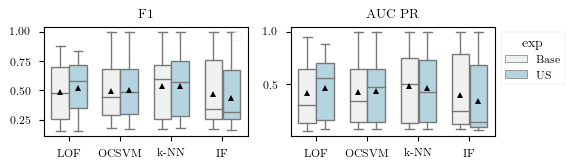

In [9]:
tmp_df = pd.concat([baseline_df, us1_df[us1_df['metric'] == 'MV']])
to_label = dict(
    f1='F1', f1_pa='F1 Point adjusted', aucpr='AUC PR', aucroc='AUC ROC'
)
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    ax = sns.boxplot(
        data=tmp_df,
        y=y,
        x='detector',
        hue='exp',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])
sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
# fig.savefig(
#     'images/numenta_base_us1_comparison.pdf', format='pdf', bbox_inches='tight'
# )


Now, we look at model selection performance using the unsupervised metrics.

In [10]:
def select_best_model(keys, group):
    if keys[0] == 'MV':
        best_m = group['metric_value'].argmin()
    else:
        best_m = group['metric_value'].argmax()
    best_pr = group['aucpr'].argmax()
    best_f1 = group['f1'].argmax()
    return pd.Series(
        {
            'best_wrt_metric': group.iloc[best_m]['detector'],
            'best_aucpr_wrt_metric': group.iloc[best_m]['aucpr'],
            'best_wrt_aucpr': group.iloc[best_pr]['detector'],
            'best_aucpr': group.iloc[best_pr]['aucpr'],
            'same': best_m == best_pr,
        }
    )


r = us1_df.groupby(['metric', 'dataset']).apply(
    lambda x: select_best_model(x.name, x)
)


[Text(0, 0, 'Best AUCPR w.r.t. metric'), Text(1, 0, 'Best AUCPR')]

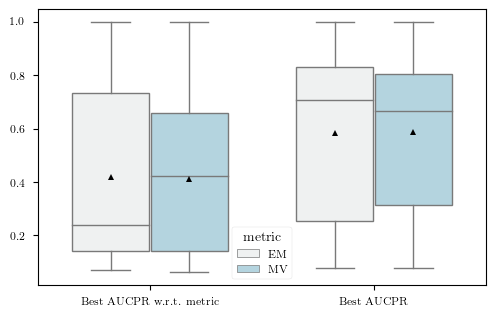

In [11]:
r_tmp = pd.melt(
    r.reset_index(),
    value_vars=['best_aucpr_wrt_metric', 'best_aucpr'],
    id_vars=['metric'],
)
fig, axs = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1)))
ax = sns.boxplot(
    data=r_tmp,
    x='variable',
    y='value',
    hue='metric',
    color='lightblue',
    linewidth=1,
    width=0.7,
    ax=axs,
    showmeans=True,
    meanprops={
        'marker': '^',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'markersize': '4',
    },
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(['Best AUCPR w.r.t. metric', 'Best AUCPR'])
# fig.savefig(
#     'images/numenta_model_selection_wrt_metrics.pdf',
#     format='pdf',
#     bbox_inches='tight',
# )


Metrics are unable to recover best models w.r.t. AUC-PR. The result for NAB datasets is even worse than for UCR datasets. Using MV metric values only 2 of 25 times the best model could be recovered.

In [12]:
r.reset_index()[['metric', 'same']].groupby('metric').value_counts()


metric  same 
EM      False    18
        True      7
MV      False    23
        True      2
dtype: int64

#### Comparison of potential US upper bound to baseline

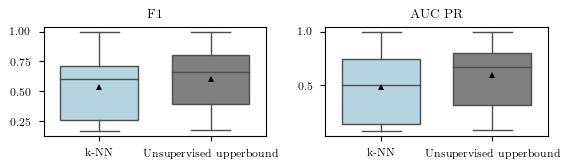

In [13]:
baseline_df['Experiment'] = 'Base'
to_label = dict(
    f1='F1', f1_pa='F1 Point adjusted', aucpr='AUC PR', aucroc='AUC ROC'
)
knn_base = baseline_df[baseline_df['detector'] == 'k-NN']
d = us1_df.loc[us1_df.groupby(['metric', 'dataset'])['aucpr'].idxmax()]
d = d[d['metric'] == 'MV']
tmp_df = pd.concat([knn_base, d])

fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]

    ax = sns.boxplot(
        data=tmp_df,
        y=y,
        x='exp',
        ax=ax,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
        palette={
        'US': 'grey',
        'Base': 'lightblue',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(['k-NN', 'Unsupervised upperbound'])
#     if i != 1:
#         ax.legend([])
# sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
# fig.savefig(
#     'images/numenta_base_potential_upperbound.pdf',
#     format='pdf',
#     bbox_inches='tight',
# )


Performance of EUS pipelines is showed next. 

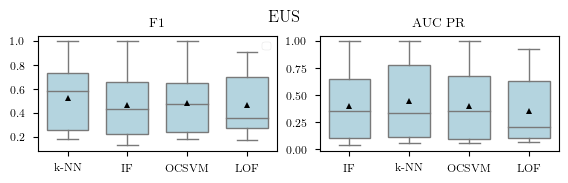

In [14]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us2_df[us2_df['metric'] == 'MV']
        .groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=us2_df,
        y=y,
        x='detector',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])

fig.suptitle('EUS', y=1)
fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
# fig.savefig('images/numenta_us2.pdf', format='pdf', bbox_inches='tight')


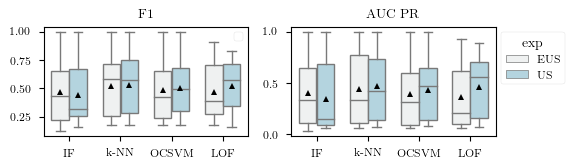

In [15]:
tmp_df = pd.concat([us2_df[us2_df['metric'] == 'MV'], us1_df[us1_df['metric'] == 'MV']])
to_label = dict(
    f1='F1', f1_pa='F1 Point adjusted', aucpr='AUC PR', aucroc='AUC ROC'
)
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    ax = sns.boxplot(
        data=tmp_df,
        y=y,
        x='detector',
        hue='exp',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])
sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
# fig.savefig(
#     'images/numenta_base_us1_comparison.pdf', format='pdf', bbox_inches='tight'
# )


## EUS-AE: Autoencoder within unsupervised metrics 

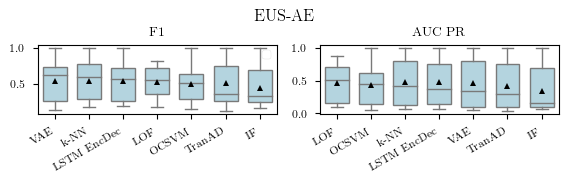

In [16]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us3_df[us3_df['metric'] == 'MV']
        .groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=us3_df[us3_df['metric'] == 'MV'],
        y=y,
        x='detector',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])

    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=30, horizontalalignment='right'
    )


fig.suptitle('EUS-AE', y=1)
fig.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()
# fig.savefig('images/numenta_us3.pdf', format='pdf', bbox_inches='tight')


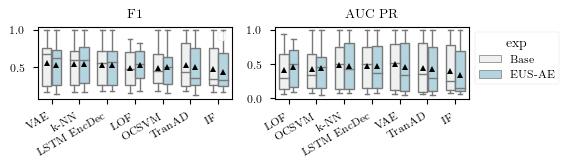

In [17]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
tmp_df = pd.concat(
    [
        baseline_df.query('detector not in ["GTA", "DWTMLEAD"]'),
        us3_df[us3_df['metric'] == 'MV'],
    ]
)

for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us3_df[us3_df['metric'] == 'MV']
        .groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=tmp_df,
        y=y,
        x='detector',
        ax=ax,
        hue='exp',
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])

    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=30, horizontalalignment='right'
    )

sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))
fig.tight_layout()
plt.show()
# fig.savefig('images/numenta_base_us3_.pdf', format='pdf', bbox_inches='tight')


## EUS-VAE: VAE within unsupervised metrics 

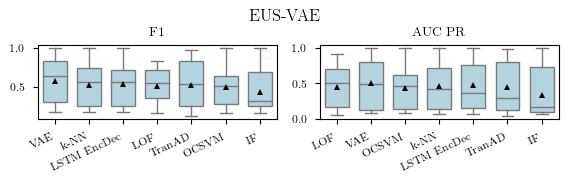

In [18]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us5_df[us5_df['metric'] == 'MV']
        .groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=us5_df[us5_df['metric'] == 'MV'],
        y=y,
        x='detector',
        ax=ax,
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])

    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=25, horizontalalignment='right'
    )

fig.suptitle('EUS-VAE', y=1)
fig.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()
# fig.savefig('images/numenta_us5.pdf', format='pdf', bbox_inches='tight')


Comparison between EUS-AE and EUS-VAE

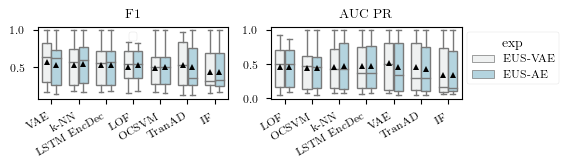

In [19]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))
tmp_df = pd.concat(
    [us5_df[us5_df['metric'] == 'MV'], us3_df[us3_df['metric'] == 'MV']]
)

for i, y in enumerate(['f1', 'aucpr']):
    ax = axs[i]
    order = (
        us3_df[us3_df['metric'] == 'MV']
        .groupby(by=['detector'])[y]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )
    ax = sns.boxplot(
        data=tmp_df,
        y=y,
        x='detector',
        ax=ax,
        hue='exp',
        order=order,
        linewidth=1,
        width=0.7,
        color='lightblue',
        showmeans=True,
        meanprops={
            'marker': '^',
            'markerfacecolor': 'black',
            'markeredgecolor': 'black',
            'markersize': '4',
        },
    )
    ax.set(title=to_label[y])
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i != 1:
        ax.legend([])

    ax.set_xticklabels(
        ax.get_xticklabels(), rotation=30, horizontalalignment='right'
    )

sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))
fig.tight_layout()
plt.show()
# fig.savefig('images/numenta_us5_.pdf', format='pdf', bbox_inches='tight')


Comparison of all potential pipeline upperbounds using the MV metric against baselines of VAE and k-NN

/tmp/ipykernel_3023381/2364640864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_df.loc[:, 'exp'] = 'k-NN'
/tmp/ipykernel_3023381/2364640864.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwt_df.loc[:, 'exp'] = 'VAE'
/tmp/ipykernel_3023381/2364640864.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
 

<Axes.ArtistList of 0 artists>


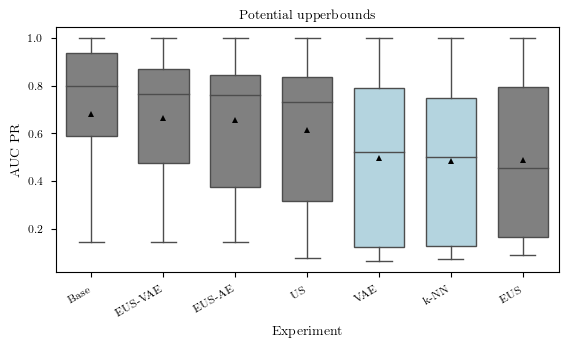

In [20]:
knn_df = baseline_df[baseline_df['detector'] == 'k-NN']
knn_df.loc[:, 'exp'] = 'k-NN'
dwt_df = baseline_df[baseline_df['detector'] == 'VAE']
dwt_df.loc[:, 'exp'] = 'VAE'
tmp_df = pd.concat(
    [knn_df, baseline_df, us1_df, us3_df, us5_df, us2_df, dwt_df]
)
tmp = tmp_df.groupby(['exp', 'dataset']).max().reset_index()
order = (
    tmp_df.groupby(by=['exp', 'dataset'])
    .max()
    .groupby('exp')
    .median()['aucpr']
    .sort_values(ascending=False)
    .index.tolist()
)
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1)))
ax = sns.boxplot(
    data=tmp,
    x='exp',
    y='aucpr',
    linewidth=1,
    width=0.7,
    order=order,
    ax=ax,
    showmeans=True,
    meanprops={
        'marker': '^',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'markersize': '4',
    },
    palette={
        'EUS-AE': 'grey',
        'EUS-VAE': 'grey',
        'k-NN': 'lightblue',
        'Base': 'grey',
        'US': 'grey',
        'EUS': 'grey',
        'VAE': 'lightblue',
    },
)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=30, horizontalalignment='right'
)
ax.set_xlabel('Experiment')
ax.set_ylabel('AUC PR')
print(ax.artists)
ax.set_title('Potential upperbounds')

plt.tight_layout()
plt.show()
fig.savefig('images/numenta_us_vs_base.pdf', format='pdf', bbox_inches='tight')
# 

## META pipelines

In [21]:
records = []
best_models = load('./results/numenta_best_models.joblib')
for model, dataset in best_models:
    if dataset not in baseline_df['dataset'].values:
        continue

    r = (
        baseline_df[
            (baseline_df['detector'] == detectors_dict[model])
            & (baseline_df['dataset'] == dataset)
        ]
        .iloc[0]
        .to_dict()
    )
    r['metric_value'] = 0
    r['metric'] = 'Base'
    records.append(r)


meta_df1 = pd.DataFrame.from_records(records)
meta_df1['exp'] = 'META_base'


In [22]:
records = []
best_models = load('./results/numenta_best_models.joblib')
for model, dataset in best_models:
    if dataset not in baseline_df['dataset'].values:
        continue
    if model not in ['gta', 'dwtmlead']:
        with open(
            f'./model/{model}/numenta_unsupervised_aev2/{dataset}/mv.yaml'
        ) as f:
            r = yaml.unsafe_load(f)
            r['detector'] = detectors_dict[model]
            r['metric_value'] = r.pop('metric')
            r['metric'] = 'MV'
            r['dataset'] = dataset
            records.append(r)
    else:
        if model == 'dwtmlead':
            r = (
                baseline_df[
                    (baseline_df['detector'] == 'DWTMLEAD')
                    & (baseline_df['dataset'] == dataset)
                ]
                .iloc[0]
                .to_dict()
            )
            r['metric_value'] = 0
            r['metric'] = 'Base'
            records.append(r)
        if model == 'gta':
            r = (
                baseline_df[
                    (baseline_df['detector'] == 'GTA')
                    & (baseline_df['dataset'] == dataset)
                ]
                .iloc[0]
                .to_dict()
            )
            r['metric_value'] = 0
            r['metric'] = 'Base'
            records.append(r)

meta_df = pd.DataFrame.from_records(records)
meta_df['exp'] = 'META'


In [23]:
records = []
best_models = load('./results/numenta_best_models_tsfresh.joblib')
for model, dataset in best_models:
    if dataset not in baseline_df['dataset'].values:
        continue
    r = (
        baseline_df[
            (baseline_df['detector'] == detectors_dict[model])
            & (baseline_df['dataset'] == dataset)
        ]
        .iloc[0]
        .to_dict()
    )
    r['metric_value'] = 0
    r['metric'] = 'Base'
    records.append(r)


meta_df2 = pd.DataFrame.from_records(records)
meta_df2['exp'] = 'META-ts_base'


In [24]:
records = []
best_models = load('./results/numenta_best_models_tsfresh.joblib')
for model, dataset in best_models:
    if dataset not in baseline_df['dataset'].values:
        continue
    if model not in ['gta', 'dwtmlead']:
        with open(
            f'./model/{model}/numenta_unsupervised_aev2/{dataset}/mv.yaml'
        ) as f:
            r = yaml.unsafe_load(f)
            r['detector'] = detectors_dict[model]
            r['metric_value'] = r.pop('metric')
            r['metric'] = 'MV'
            r['dataset'] = dataset
            records.append(r)
    else:
        if model == 'dwtmlead':
            r = (
                baseline_df[
                    (baseline_df['detector'] == 'DWTMLEAD')
                    & (baseline_df['dataset'] == dataset)
                ]
                .iloc[0]
                .to_dict()
            )
            r['metric_value'] = 0
            r['metric'] = 'Base'
            records.append(r)
        if model == 'gta':
            r = (
                baseline_df[
                    (baseline_df['detector'] == 'GTA')
                    & (baseline_df['dataset'] == dataset)
                ]
                .iloc[0]
                .to_dict()
            )
            r['metric_value'] = 0
            r['metric'] = 'Base'
            records.append(r)

meta_tsfresh_df = pd.DataFrame.from_records(records)
meta_tsfresh_df['exp'] = 'META-ts'


Plot performance of all meta pipelines against potenital baseline and baselines of k-NN and VAE.

/tmp/ipykernel_3023381/2749348520.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .median()['aucpr']


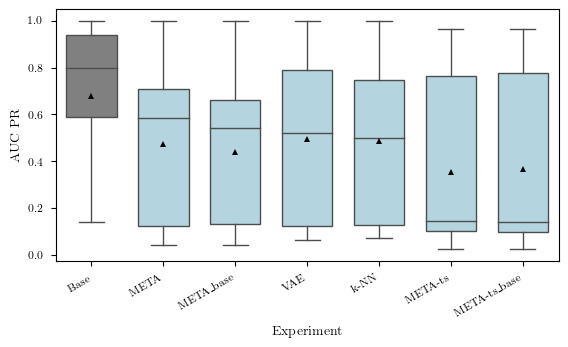

In [25]:
tmp_df = pd.concat(
    [knn_df, dwt_df, baseline_df, meta_df, meta_tsfresh_df, meta_df1, meta_df2]
)
tmp = tmp_df.groupby(['exp', 'dataset']).max().reset_index()
order = (
    tmp_df.groupby(by=['exp', 'dataset'])
    .max()
    .groupby('exp')
    .median()['aucpr']
    .sort_values(ascending=False)
    .index.tolist()
)

fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1)))
sns.boxplot(
    data=tmp,
    x='exp',
    y='aucpr',
    color='lightblue',
    linewidth=1,
    width=0.7,
    order=order,
    ax=ax,
    showmeans=True,
    meanprops={
        'marker': '^',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'markersize': '4',
    },
    palette={
        'k-NN': 'lightblue',
        'META': 'lightblue',
        'META-ts': 'lightblue',
        'EUS': 'grey',
        'META_base': 'lightblue',
        'Base': 'grey',
        'META-ts_base': 'lightblue',
        'VAE': 'lightblue',
    },
)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=30, horizontalalignment='right'
)
ax.set_xlabel('Experiment')
ax.set_ylabel('AUC PR')
plt.tight_layout()
plt.show()
# fig.savefig(
#     'images/numenta_meta_us_vs_base.pdf', format='pdf', bbox_inches='tight'
# )


/tmp/ipykernel_3023381/1644167453.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .median()['f1']


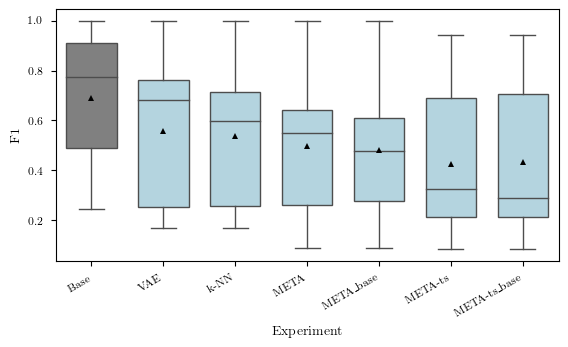

In [26]:
tmp_df = pd.concat(
    [knn_df, dwt_df, baseline_df, meta_df, meta_tsfresh_df, meta_df1, meta_df2]
)
tmp = tmp_df.groupby(['exp', 'dataset']).max().reset_index()
order = (
    tmp_df.groupby(by=['exp', 'dataset'])
    .max()
    .groupby('exp')
    .median()['f1']
    .sort_values(ascending=False)
    .index.tolist()
)

fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1)))
sns.boxplot(
    data=tmp,
    x='exp',
    y='f1',
    color='lightblue',
    linewidth=1,
    width=0.7,
    order=order,
    ax=ax,
    showmeans=True,
    meanprops={
        'marker': '^',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'markersize': '4',
    },
    palette={
        'k-NN': 'lightblue',
        'META': 'lightblue',
        'META-ts': 'lightblue',
        'EUS': 'grey',
        'META_base': 'lightblue',
        'VAE': 'lightblue',
        'Base': 'grey',
        'META-ts_base': 'lightblue',
    },
)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=30, horizontalalignment='right'
)
ax.set_xlabel('Experiment')
ax.set_ylabel('F1')
plt.tight_layout()
plt.show()
# fig.savefig('images/numenta_meta_us_vs_base.pdf', format='pdf', bbox_inches='tight')
